## Pre-Processing and Modeling.

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Linear import.
from sklearn.linear_model import LinearRegression

# kNN import
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#DBSCAN
from sklearn.cluster import DBSCAN

import warnings
warnings.filterwarnings('ignore')

## Reading in the cleaned dataset.

In [2]:
spot = pd.read_csv('../Data/clean/final.csv')

In [3]:
spot.head()

,song title,artist,top genre,year,added,bpm,energy,dance,dB,live,valence,dur,acous,spch,popularity
0,Chop Suey!,System Of A Down,alternative metal,2001,1969‑12‑31,127,93,42,-4,13,29,210,0,12,86
1,Just Pretend,Bad Omens,american metalcore,2022,1969‑12‑31,140,83,46,-5,10,20,205,0,8,81
2,Monster,Skillet,alternative metal,2009,1969‑12‑31,135,96,64,-2,8,69,178,4,7,80
3,Popular Monster,Falling In Reverse,alternative metal,2019,1969‑12‑31,165,90,46,-4,10,36,221,1,9,78
4,Watch The World Burn,Falling In Reverse,alternative metal,2023,1969‑12‑31,162,78,40,-6,21,35,204,1,13,78


## Using Linear Regression to find coefficients.

In [4]:
#Create my X and y variables.
X = spot[['bpm', 'dance', 'valence', 'popularity', 'dur']]
y = spot['energy']

In [5]:
#Check the shapes.
X.shape
y.shape

print(X.shape, y.shape)

(1288, 5) (1288,)


In [6]:
#Instantiate and fit.
lr = LinearRegression()

lr.fit(X, y)

LinearRegression()

In [7]:
#Make into a dataframe to easily see what features played most in energy.
pd.DataFrame(lr.coef_, index = X.columns)

,0
bpm,0.138393
dance,0.500889
valence,0.400533
popularity,0.279964
dur,0.070473


***For every 1 unit increase in X, we expect energy to increase by Bi holding all else constant.***

+ Holding energy constant, for every 1 unit increase in danceability, we will see a .5 increase in energy. 

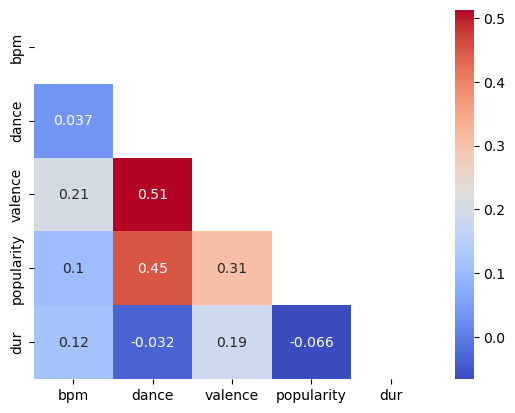

In [8]:
#Creating a heatmap to look at correlation among the features.
X.corr()

mask = np.zeros_like(X.corr())

mask[np.triu_indices_from(mask)] = True

sns.heatmap(X.corr(),
           cmap = 'coolwarm',
           mask = mask,
           annot = True);

+ It is interesting how the longer a song the more popularity and danceabilty drops.
+ Valence seems to be affected greatly by beats per minute making sense since faster tempos generally provide a ligher atmosphere.
+ Danceability has the highest correlational values with it playing a big part in the mood of things and also the popularity of a song.

## K Means Clustering

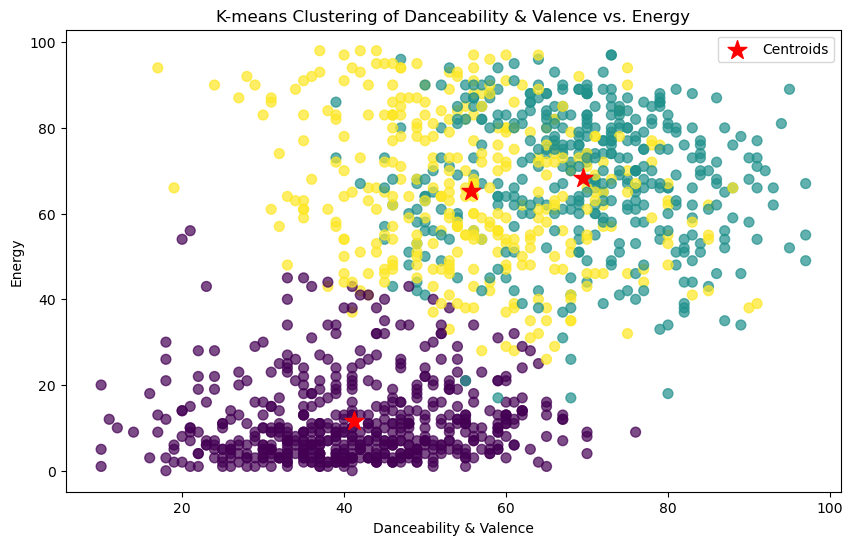

In [23]:
# Create my X.
X = spot[['dance', 'valence', 'energy']]

# Standardize the features.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the number of clusters.
num_clusters = 3

# Create a K-means model
kmeans = KMeans(n_clusters=num_clusters, random_state=12)

# Fit the model.
kmeans.fit(X_scaled)

# Get the centroids.
centroids = scaler.inverse_transform(kmeans.cluster_centers_)

# Get cluster labels for each data point.
labels = kmeans.labels_

# Create a scatter plot of the data points.
plt.figure(figsize=(10, 6))
plt.scatter(X['dance'], X['energy'], c=labels, cmap='viridis', s=50, alpha=0.7)

# Plot the centroids as red stars.
plt.scatter(centroids[:, 0], centroids[:, 2], marker='*', c='red', s=200, label='Centroids')

# Labels.
plt.xlabel('Danceability & Valence')
plt.ylabel('Energy')
plt.title('K-means Clustering of Danceability & Valence vs. Energy')
plt.legend()
plt.show();

# Finding the best K value.

In [10]:
#Large intertia score so we may have too many clusters.
kmeans.inertia_

1338.8035979544031

In [11]:
# Create a list with different K values to see how the intertias will vary.
k_values = range(1,11)
inertias = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=12)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    
inertias

[3864.0,
 1746.2140946363968,
 1338.8035979544031,
 1148.3790895853795,
 960.3820074837456,
 841.3199147425623,
 735.2815132556666,
 679.0544288560868,
 630.1938347420178,
 587.1612132313156]

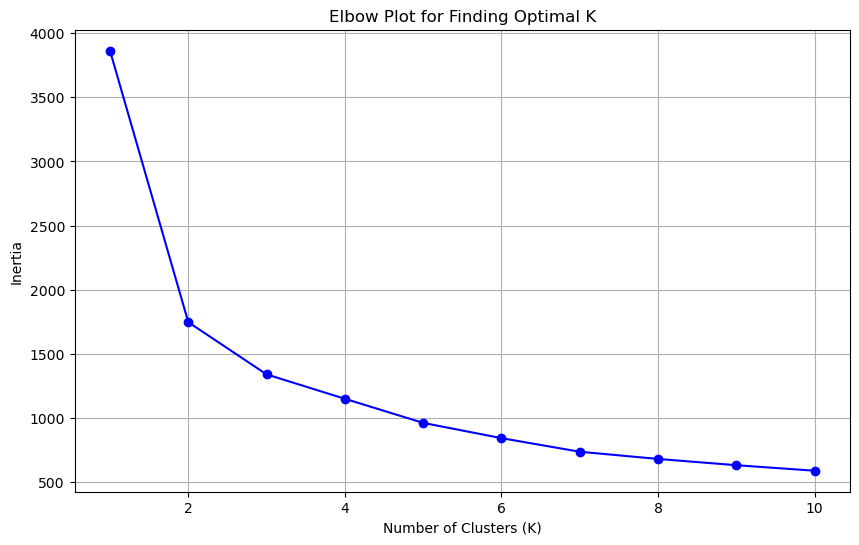

In [24]:
# Created the elbow plot to find the optimal k value via intertia scores.
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertias, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Plot for Finding Optimal K')
plt.grid(True)
plt.show()

From the elbow plot and the intertia list it is looking like 2 is the magic number.

In [13]:
# Not the highest silhouette score either so my clusters aren't very far apart from eachother.
silhouette_score(X_scaled, kmeans.labels_)

0.300318166437911

In [14]:
# Running different K values to see what the best silhouette score will be.

silhouette_list = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state = 12)
    kmeans.fit(X_scaled)
    silhouette_list.append(silhouette_score(X_scaled, kmeans.labels_))
    
silhouette_list

[0.46621546871832575,
 0.3708330010410745,
 0.2997468288278237,
 0.29672149730154634,
 0.29273543016812226,
 0.3060133817845387,
 0.300129265362734,
 0.2912463432760309,
 0.300318166437911]

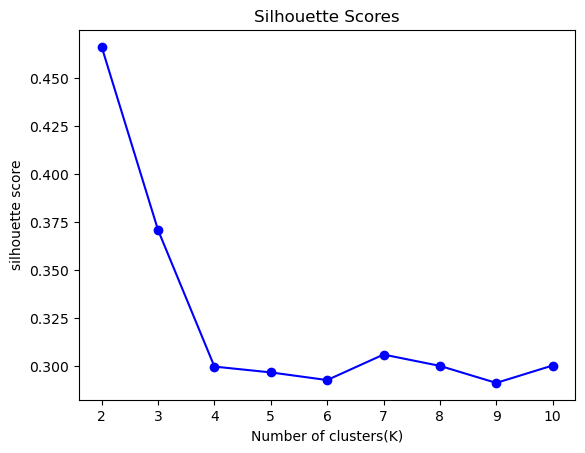

In [15]:
# Created an elbow plot for the silhouette scores.

plt.plot(range(2, 11), silhouette_list, marker = 'o', color = 'blue')
plt.xlabel('Number of clusters(K)')
plt.ylabel('silhouette score')
plt.title('Silhouette Scores');

Based off the scores and the chart the optimal value of k for silhouette scores is 2. 

## DBSCAN

In [16]:
# After adjusting epsilon values for a while it became very apparent that the clustering was not clearly separated in the dataset, so all models were poor.
dbscan = DBSCAN(eps = .39)
dbscan.fit(X_scaled)
pd.Series(dbscan.labels_).unique()

array([ 0, -1])

In [17]:
# DBSCAN silhouette score was only positive with 2 clusters after iteration and very bad.
silhouette_score(X_scaled, dbscan.labels_)

0.1414199146675286

In [18]:
# Created a column for the clusters to gather more insights.
spot['db cluster'] = dbscan.labels_

In [19]:
# Pretty much everything is 1 cluster.
spot['db cluster'].value_counts(normalize = True)

 0    0.953416
-1    0.046584
Name: db cluster, dtype: float64

In [20]:
# Separated the two clusters into dataframes to peer more into why there is a difference.
clust_0 = spot.loc[spot['db cluster'] == 0]
clust_1 = spot.loc[spot['db cluster'] == -1]

In [21]:
spot.groupby('db cluster').mean().T[[-1, 0]]

db cluster,-1,0
year,2015.133333,2016.858306
bpm,126.633333,116.965798
energy,55.133333,42.760586
dance,54.633333,53.733713
dB,-10.400000,-13.237785
live,19.566667,15.675081
valence,44.966667,39.105863
dur,196.050000,192.034202
acous,33.450000,53.890065
spch,9.450000,6.657166


+ Interestingly enough, the smaller cluster was comprised of faster bpm, higher energy , and less acoustic tendencies. This could be specifiying a genre like electro dance music who exhibit all of those qualities.

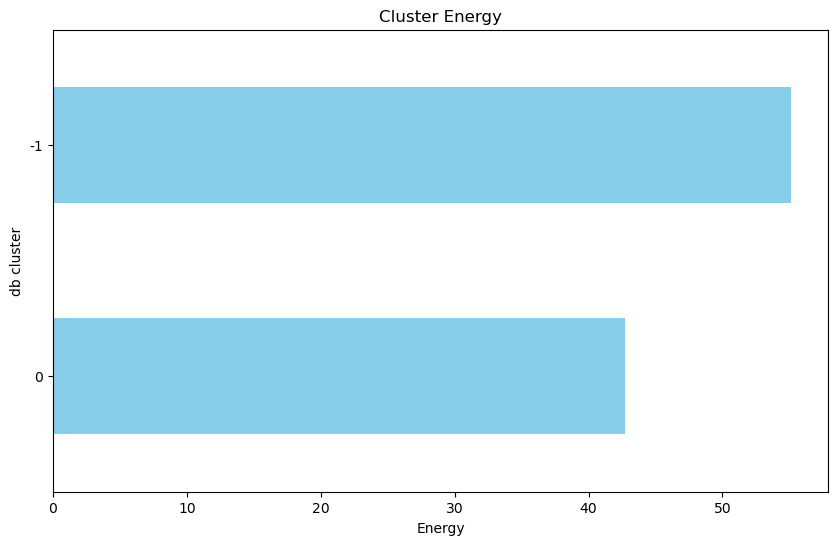

In [22]:
# Creating a horizontal bar plot to show the difference between energy in the two clusters.

cluster_mean_energy = spot.groupby('db cluster')['energy'].mean()

# Create a horizontal bar plot
ax = cluster_mean_energy.plot(kind='barh', figsize=(10, 6), color='skyblue')
ax.set_xlabel('Energy')
ax.set_title('Cluster Energy') 
ax.invert_yaxis()
plt.show();

## Conclusion and Recommendations

In both the kmeans and dbscan I ran into the issue of the clusters not being clearly separated from eachother. The ideal value for k for the kmeans was 2 clusters while running the dbscan and silhoutte scores the recommended amount of clusters were 2. While the Kmeans model did run better than the DBSCAN the models were still running poorly overall with the best silhouette score being a 46.7%. It would probably be more beneficial to eliminate all the top billboard songs and keep the playlists specifically only set to moods to get more of a clear separation in my clusters. 